# Pré traitement des données

## I. Conversion C3D en JSON rééchantilloné à 50 Hz

In [1]:
import numpy as np
import ezc3d
import json
from scipy.signal import resample,butter, lfilter, freqz
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#c3d = ezc3d.c3d(file_path)
#events = c3d['parameters']['EVENT']['LABELS']['value'] # Récupérer les événements
#temps_events = c3d['parameters']['EVENT']['TIMES']['value'] # Récupérer les temps correspondant aux événements

In [3]:
def recuperer_evenements(file_path):
    """
    Cette fonction extrait les événements du fichier C3D.

    Args:
        file_path (str): Le chemin du fichier C3D.

    Returns:
        dict: Un dictionnaire contenant les événements et leur temps correspondant.
    """
    c3d = ezc3d.c3d(file_path)
    events = c3d['parameters']['EVENT']['LABELS']['value'] # Récupérer les événements
    temps_events = c3d['parameters']['EVENT']['TIMES']['value'] # Récupérer les temps correspondant aux événements
    # Créer un DataFrame
    df = pd.DataFrame({'events': events, 'frames': temps_events[1]})
    # Supprimer l'index
    df.reset_index(drop=True, inplace=True)
    events_dict = df.groupby('events')['frames'].apply(list).to_dict()
    return events_dict

def butter_lowpass(cutoff, fs, order=5):
    """
    Crée les coefficients d'un filtre Butterworth passe-bas.

    Args:
        cutoff (float): Fréquence de coupure du filtre.
        fs (float): Fréquence d'échantillonnage du signal.
        order (int): Ordre du filtre.

    Returns:
        tuple: Coefficients du filtre (b, a).
    """
    nyq = 0.5 * fs # Fréquence de Nyquist
    normal_cutoff = cutoff / nyq # Fréquence de coupure normalisée
    b, a = butter(order, normal_cutoff, btype='low', analog=False) # Création des coefficients du filtre
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """
    Applique un filtre Butterworth passe-bas à un signal.

    Args:
        data (array_like): Signal à filtrer.
        cutoff (float): Fréquence de coupure du filtre.
        fs (float): Fréquence d'échantillonnage du signal.
        order (int): Ordre du filtre.

    Returns:
        array_like: Signal filtré.
    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def reechantillonnage_fc_coupure_et_association_labels_et_data(file_path, cutoff_freq=20, target_freq=50):
    """
    Cette fonction transforme les données échantillonnées à 2100 Hz en données échantillonnées à 50 Hz,
    puis applique un filtre Butterworth passe-bas avec une fréquence de coupure de 20 Hz, et enfin associe les étiquettes des données aux données rééchantillonnées et filtrées.

    Args:
        file_path (str): Le chemin du fichier C3D.
        cutoff_freq (float): Fréquence de coupure du filtre Butterworth (20 Hz).
        target_freq (float): Fréquence cible après rééchantillonnage (50 Hz).

    Returns:
        tuple: Un tuple contenant un dictionnaire fusionnant les étiquettes et les données rééchantillonnées et filtrées, et les temps rééchantillonnés.
    """
    c3d = ezc3d.c3d(file_path)
    labels = c3d['parameters']['ANALOG']['LABELS']['value'] # Récupérer les étiquettes des données
    original_freq = c3d['parameters']['ANALOG']['RATE']['value'][0] # Récupérer la fréquence d'échantillonnage
    data = c3d['data']['analogs'] # Récupérer les données
    nb_frame = len(data[0][0]) # Récupérer le nombre de frames
    target_freq = 50  # fréquence de rééchantillonnage
    
    # Rééchantillonnage des données
    nb_samples_target = int(nb_frame * (target_freq / original_freq)) # Calcul du nombre d'échantillons cible
    resampled_times = np.linspace(0., (nb_frame / original_freq), num=nb_samples_target) # Création d'un tableau de temps rééchantillonné
    resampled_data = np.zeros((len(labels), nb_samples_target)) # Création d'un tableau de zéros de la taille des données rééchantillonnées
    for i in range(len(labels)): # Pour chaque étiquette
        resampled_data[i, :] = resample(data[0][i, :], nb_samples_target) # Rééchantillonnage des données

    fusion_label_data = {}
    for i, label in enumerate(labels): # Pour chaque étiquette
        fusion_label_data[label] = resampled_data[i, :] # Associer les étiquettes aux données rééchantillonnées
        
    # Filtrage des données rééchantillonnées
    filtered_data = np.zeros_like(resampled_data) # Création d'un tableau de zéros de la même taille que les données rééchantillonnées
    for i in range(len(labels)): # Pour chaque étiquette
        filtered_data[i, :] = butter_lowpass_filter(resampled_data[i, :], cutoff_freq, target_freq) # Appliquer un filtre passe-bas

    fusion_label_data = {}
    for i, label in enumerate(labels): 
        fusion_label_data[label] = filtered_data[i, :] # Associer les étiquettes aux données filtrées
    
    return fusion_label_data, resampled_times
    

def filtrer_labels(fusion_label_data):
    """
    Cette fonction filtre les étiquettes des données pour ne garder que celles liées à l'accéléromètre et au gyroscope.

    Args:
        fusion_label_data (dict): Dictionnaire contenant les étiquettes et les données associées.

    Returns:
        tuple: Un tuple contenant une liste des étiquettes filtrées et un dictionnaire des données associées aux étiquettes filtrées.
    """
    labels_filtre = []
    labels_data_filtre = {}
    for label, valeurs in fusion_label_data.items(): # Pour chaque étiquette et ses valeurs
        if 'ACC' in label or 'GYRO' in label: # Si l'étiquette contient 'ACC' ou 'GYRO'
            labels_filtre.append(label) # Ajouter l'étiquette à la liste des étiquettes filtrées
            labels_data_filtre[label] = valeurs # Ajouter les valeurs associées à l'étiquette dans le dictionnaire des données filtrées
    return labels_filtre, labels_data_filtre

def calcul_norme(labels_data_filtre):
    """
    Cette fonction calcule les normes des données filtrées.

    Args:
        labels_data_filtre (dict): Dictionnaire contenant les étiquettes et les données associées, filtrées.

    Returns:
        dict: Un dictionnaire contenant les normes calculées.
    """
    normes = {}
    traite = set() # Créer un ensemble vide pour stocker les capteurs, les côtés et les mesures déjà traités
    for key, value in labels_data_filtre.items():
        parts = key.split('_') # Séparer l'étiquette en parties
        sensor = parts[0] # Récupérer le capteur
        side = parts[1] # Récupérer le côté
        measure = parts[2] # Récupérer la mesure (GYRO ou ACC)
        
        if (sensor, side, measure) not in traite: # Si le capteur, le côté et la mesure n'ont pas déjà été traités
            traite.add((sensor, side, measure)) # Ajouter le capteur, le côté et la mesure à l'ensemble des éléments traités
            
            if "ACC" in measure:
                # Obtention des axes X, Y et Z
                axe_X = (labels_data_filtre[f'{sensor}_{side}_{measure}_X'])
                axe_Y = (labels_data_filtre[f'{sensor}_{side}_{measure}_Y'])
                axe_Z = (labels_data_filtre[f'{sensor}_{side}_{measure}_Z'])
            
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) - 1 # Calcul de la norme auquelle on soustrait 1 pour enlever la gravité
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme
                
            else:
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
        
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) 
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme

    return normes

def creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, resampled_times, events_dict, normes):
    """
    Cette fonction crée une structure JSON à partir des données filtrées et d'autres informations.

    Args:
        labels_data_filtre (dict): Dictionnaire contenant les étiquettes et les données associées, filtrées.
        patient_id (int): Identifiant du patient.
        date_de_naissance (str): Date de naissance du patient.
        medicaments (str): Médicaments pris par le patient.
        resampled_times (ndarray): Temps rééchantillonné.
        events_dict (dict): Dictionnaire contenant les événements et leur temps correspondant.
        normes (dict): Dictionnaire contenant les normes calculées.

    Returns:
        dict: Structure JSON contenant les données et les métadonnées.
    """
    json_data = {
        "metadata": {
            "Détails du patient": {
                "Identifiant": patient_id,
                "Date de naissance": date_de_naissance,
                "Medicaments": medicaments
            },
            "Temps": resampled_times.tolist()
        }
    }
    
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]
        
        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        json_data[sensor][side][measure][axis] = value.tolist()
        
    for key in normes:
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]

        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        # Insérer la norme au même niveau d'indentation que l'axe
        json_data[sensor][side][measure][axis] = value.tolist()
        json_data[sensor][side][measure]["norme"] = normes[key].tolist()
    
    # Ajouter les événements FOG
    json_data["FOG"] = {
        "Debut": events_dict["FOG_begin"],
        "Fin": events_dict["FOG_end"]
    }
    
    # Ajouter tous les évènements sauf FOG
    del events_dict["FOG_begin"]
    del events_dict["FOG_end"]
    
    json_data["Parcours"] = events_dict
    
    return json_data

def creation_json_grace_c3d(file_path, patient_id, date_de_naissance, medicaments, output_path):
    """
    Cette fonction crée un fichier JSON à partir d'un fichier C3D.

    Args:
        file_path (str): Le chemin du fichier C3D.
        patient_id (int): Identifiant du patient.
        date_de_naissance (str): Date de naissance du patient.
        medicaments (str): Médicaments pris par le patient.
        output_path (str): Le chemin de sortie du fichier JSON.
    """
    events_dict = recuperer_evenements(file_path) 
    fusion_label_data, resampled_times = reechantillonnage_fc_coupure_et_association_labels_et_data(file_path)
    labels_filtre, labels_data_filtre = filtrer_labels(fusion_label_data)
    normes = calcul_norme(labels_data_filtre)
    json_structure = creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, resampled_times, events_dict, normes)
    
    with open(output_path, "w") as fichier_json:
        json.dump(json_structure, fichier_json, indent=4)

# Utilisation de la fonction pour traiter le fichier C3D et générer le fichier JSON
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 16 - Anthony.c3d"
fichier_brut_1 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/MORETTY_Daniel_1963-06-23_MODA1963/2023-07-07/2023-07-07_overlay_unspecified/Video overlay 1.c3d"
fichier_brut_16 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 16 update.c3d"
fichier_brut_3 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/MORETTY_Daniel_1963-06-23_MODA1963/2023-07-07/2023-07-07_overlay_unspecified/Video overlay 3.c3d"


patient_id = 1234
date_de_naissance = 45
medicaments = "ON"
chemin_fichier_json_16_update = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - update.json"
chemin__fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 1.json"
chemin__fichier_json_3 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 3.json"
creation_json_grace_c3d(fichier_brut_3, patient_id, date_de_naissance, medicaments, chemin__fichier_json_3)


Le code ne fonctionnera pas si il n'y a pas d'évènements de FOG

In [2]:
chemin_fichier_json_16 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16.json"
chemin_fichier_json_anthony = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - Anthony.json"
chemin_fichier_json_16_update = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - update.json"
chemin_fichier_json_1 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 1.json"
chemin__fichier_json_3 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 3.json"

# Charger le fichier JSON
with open(chemin_fichier_json_16, "r") as fichier_json:
    donnees_patient_16 = json.load(fichier_json)
    
with open(chemin_fichier_json_anthony, "r") as fichier_json:
    donnees_patient_anthony = json.load(fichier_json) 
    
with open(chemin_fichier_json_1, "r") as fichier_json:
    donnees_patient_1 = json.load(fichier_json)   

with open(chemin_fichier_json_16_update, "r") as fichier_json:
    donnees_patient_16_update = json.load(fichier_json)   
    
with open(chemin__fichier_json_3, "r") as fichier_json:
    donnees_patient_3 = json.load(fichier_json) 

# Accéder aux données spécifiques
#temps = donnees_patient["Rectus Femoris"]["Left"]["ACC"]["norme"]
#temps_16 = donnees_patient_16["metadata"]["Temps"]
#Norme_GYRO_tibia_16 = donnees_patient_16["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
#FOG_overlay_16 = donnees_patient_16["FOG"]
#parcours_16 = donnees_patient_16["Parcours"]

## Comparaison visuelle des évènements de FOG labellisés par deux neurologues

In [5]:
def plot_comparaison_events_neuro(time, signal, nom_evaluateur_1, fog_events_1, nom_evaluateur_2, fog_events_2):
    """
    Cette fonction permet de comparer les événements de FOG renseignés entre deux neurologues sur un signal donné.
    Args:
        time (array_like): Vecteur de temps.
        signal (array_like): Signal à tracer.
        fog_events_1 (dict): Dictionnaire contenant les instants des événements FOG évalués par le premier neurologue.
        fog_events_2 (dict): Dictionnaire contenant les instants des événements FOG pour le deuxième neurologue.
    """
    def plot_events_vertical_lines(events, color, linestyle, label):
        for event in events:
            plt.axvline(x=event, color=color, linestyle=linestyle, label=label) # Tracer une ligne verticale pour chaque événement

    events_1_begin = fog_events_1.get("Debut", []) # Récupérer les instants des événements de début de FOG pour le premier neurologue
    events_1_end = fog_events_1.get("Fin", []) # Récupérer les instants des événements de fin de FOG pour le premier neurologue
    events_2_begin = fog_events_2.get("Debut", [])  # Récupérer les instants des événements de début de FOG pour le deuxième neurologue
    events_2_end = fog_events_2.get("Fin", []) # Récupérer les instants des événements de fin de FOG pour le deuxième neurologue

    indices_1_begin = np.searchsorted(time, events_1_begin) # Rechercher les indices correspondant aux instants des événements de début de FOG pour le premier neurologue
    indices_1_end = np.searchsorted(time, events_1_end) # Rechercher les indices correspondant aux instants des événements de fin de FOG pour le premier neurologue
    indices_2_begin = np.searchsorted(time, events_2_begin) # Rechercher les indices correspondant aux instants des événements de début de FOG pour le deuxième neurologue
    indices_2_end = np.searchsorted(time, events_2_end) # Rechercher les indices correspondant aux instants des événements de fin de FOG pour le deuxième neurologue

    plt.figure(figsize=(12, 6))

    plt.plot(time, signal)

    plot_events_vertical_lines(events_1_begin, 'green', '--', f'FOG_begin - {nom_evaluateur_1}')
    plot_events_vertical_lines(events_1_end, 'red', '--', f'FOG_end - {nom_evaluateur_1}')

    plot_events_vertical_lines(events_2_begin, 'green', ':', f'FOG_begin - {nom_evaluateur_2}')
    plot_events_vertical_lines(events_2_end, 'red', ':', f'FOG_end - {nom_evaluateur_2}')

    plt.xlabel('Temps (s)')
    plt.ylabel('°/s')
    plt.title(f'Comparaison des évènements de FOG entre {nom_evaluateur_1} et {nom_evaluateur_2}')
    handles, labels = plt.gca().get_legend_handles_labels() # Récupérer les légendes et les étiquettes
    unique_labels = [] # Créer une liste vide pour stocker les étiquettes uniques
    unique_handles = [] # Créer une liste vide pour stocker les légendes uniques
    for i, label in enumerate(labels): # Pour chaque étiquette
        if label not in unique_labels: # Si l'étiquette n'est pas déjà dans la liste des étiquettes uniques
            unique_labels.append(label) # Ajouter l'étiquette à la liste des étiquettes uniques
            unique_handles.append(handles[i]) # Ajouter la légende correspondante à la liste des légendes uniques
    plt.legend(unique_handles, unique_labels)

    line_diff_begin = abs(indices_1_begin - indices_2_begin) # Calculer l'écart entre les indices des événements de début de FOG
    line_diff_end = abs(indices_1_end - indices_2_end) # Calculer l'écart entre les indices des événements de fin de FOG

    plt.text(0.5, -0.01, f'Écart de ligne :\n - FOG_Begin: {line_diff_begin}\n - FOG_End: {line_diff_end}', transform=plt.gcf().transFigure, va='center', ha='center') # Ajouter un texte pour afficher l'écart entre les lignes

    plt.tight_layout()  # Ajout pour ajuster automatiquement les positions des sous-graphiques et des légendes
    plt.show()


Je n'arrive pas à rajouter un sous-titre avec le nom du signal, car sinon j'obtiens un message d'erreur affirmant que l'image du graphique est trop lourde pour être générée

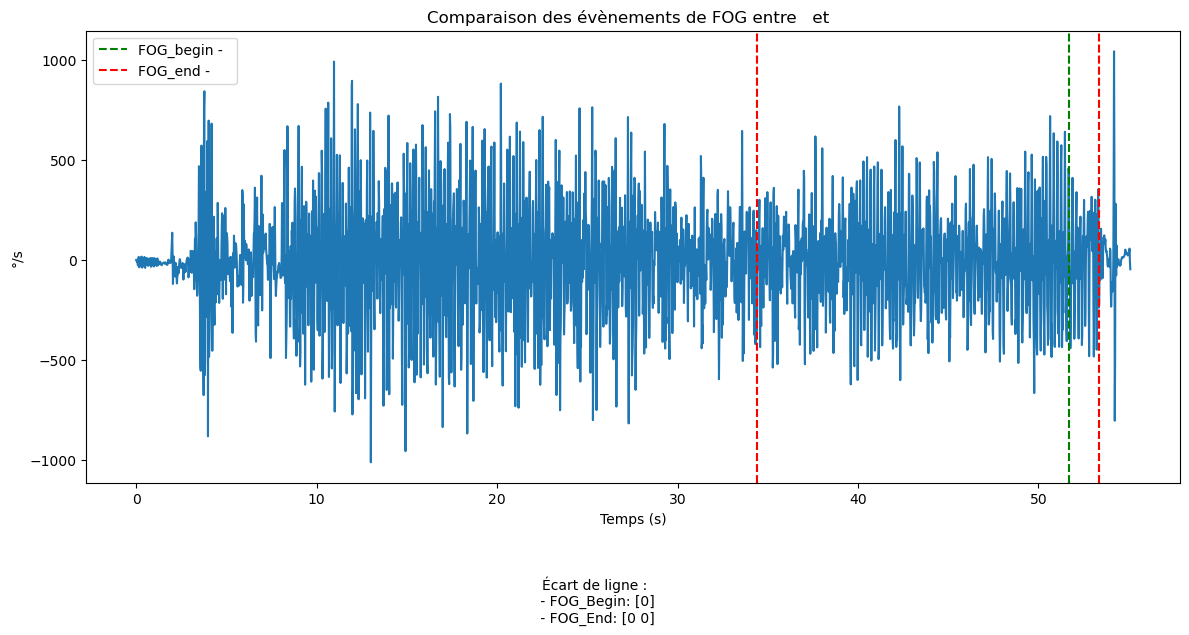

In [12]:
plot_comparaison_events_neuro(donnees_patient_3["metadata"]["Temps"], donnees_patient_3["Tibialis Anterior"]["Left"]["GYRO"]["X"], " ", donnees_patient_1["FOG"], " ",donnees_patient_1["FOG"])

In [25]:
def plot_data(data, muscle, side, sensor_type, axis, norme, temps):
    """
    Plot inertial data from a patient.
    
    Parameters:
        data (dict): Dictionary containing the patient's inertial data.
        sensor_type (str): Type of sensor data (e.g., "GYRO" or "ACC").
        muscle (str): Muscle name (e.g., "Tibialis Anterior").
        side (str): Side of the patient (e.g., "Left" or "Right").
        axis (str): Axis of the sensor data (e.g., "x", "y", or "z").
        norme (bool): Whether to plot the norme data or not.
        temps (list): List of time values.
    """
    if norme:
        data_to_plot = data[muscle][side][sensor_type]["norme"] 
        title = f"{muscle} - {side} - {sensor_type} Norme" 
    else:
        data_to_plot = data[muscle][side][sensor_type][axis]
        title = f"{muscle} - {side} - {sensor_type} - {axis}"

    plt.figure(figsize=(12, 6))
    plt.plot(temps, data_to_plot)
    plt.title(title)
    plt.xlabel("Temps(s)")
    plt.ylabel("Valeurs") 
    plt.grid(True)
    plt.show()

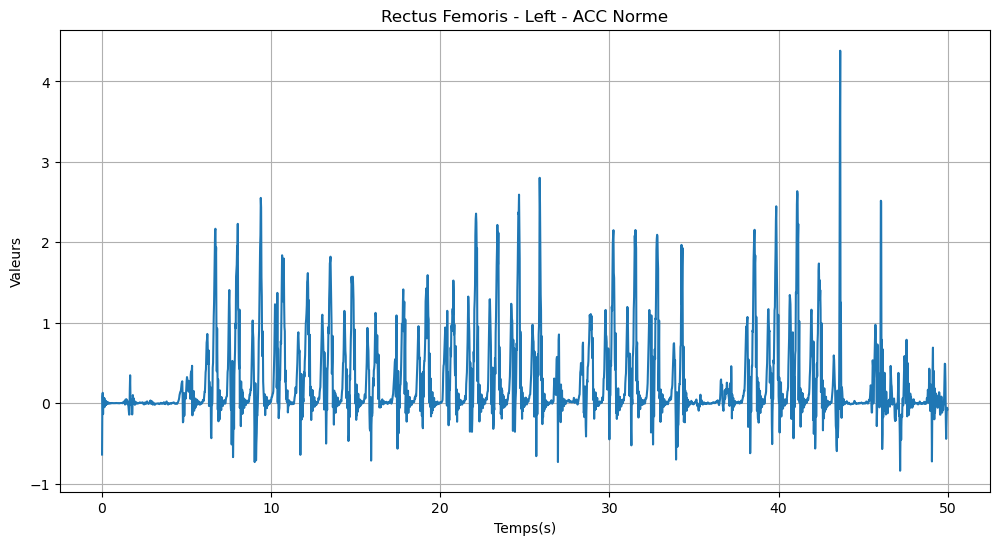

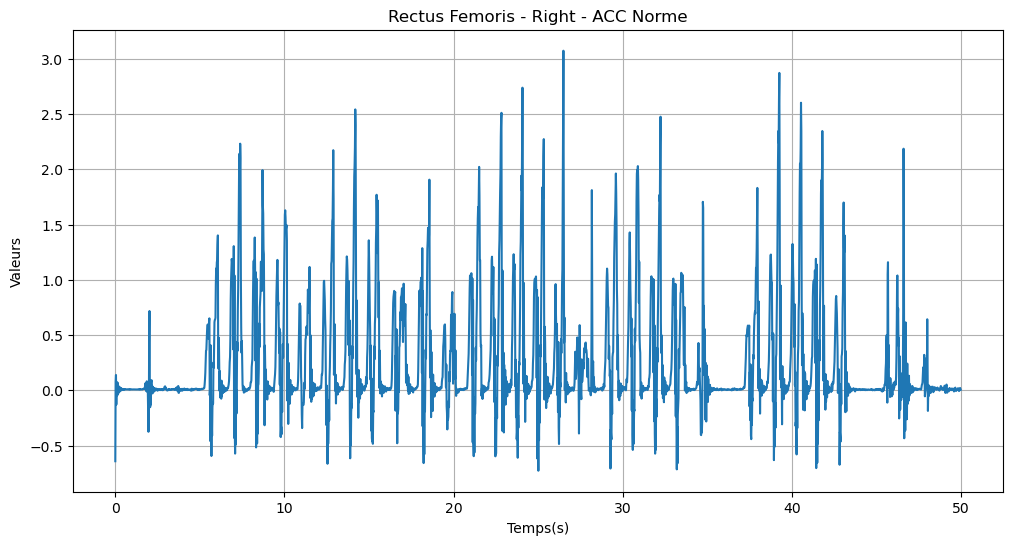

In [13]:
plot_data(donnees_patient_16, "Rectus Femoris", "Left","ACC", "norme", True, donnees_patient_16["metadata"]["Temps"])
plot_data(donnees_patient_16, "Rectus Femoris", "Right","ACC", "norme", True, donnees_patient_16["metadata"]["Temps"])


## Normaliser les données

Attention : pour les patients détectFOG il ne faudra pas oublier d'enlever la partie assise, avant de normaliser

### On crée un seuil sur l'axe de la norme du GYRO = 250

In [15]:
from scipy.signal import find_peaks
muscle_data = donnees_patient_3["Rectus Femoris"]["Right"]["ACC"]["norme"] #cheville gauche
peak_indices, _ = find_peaks(muscle_data, height=0.2)

    # S'il y a des pics, déterminer le premier et le dernier pic
if peak_indices.size > 0:
    start_index = peak_indices[0]
    end_index = peak_indices[-1]
    
#pour savoir à quel temps correspondent les pics nous allons générer le temps
temps = donnees_patient_3["metadata"]["Temps"]
FOG_d = donnees_patient_3["FOG"]

In [3]:
from scipy.signal import find_peaks

def extract_data_interval_from_peak(data,muscle_data, threshold=250):
    """
    Extrait un intervalle de données à partir d'un seuil, qui nous permettra de déterminer le début et la fin de la FOG.
    C'est à dire que le début correspondra au premier pic qui dépasse ce seuil et la fin au dernier pic.
    Libre à nous de choisir sur quel muscle nous voulons extraire un intervalle. 

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.
    - muscle_data (array-like): Les données du muscle à partir desquelles extraire l'intervalle.
    - threshold (float, optional): Le seuil pour détecter les pics. Par défaut, 250.

    Returns:
    - data_interval (dict): Un dictionnaire contenant l'intervalle de données extrait.
    """
    
    # Trouver les pics dans les données du muscle
    peak_indices, _ = find_peaks(muscle_data, height=threshold) # Trouver les pics dans les données du muscle

    # S'il y a des pics, déterminer le premier et le dernier pic
    if peak_indices.size > 0: # S'il y a des pics
        start_index = peak_indices[0] # Déterminer l'indice du premier pic
        end_index = peak_indices[-1] # Déterminer l'indice du dernier pic

        # Extraire les données d'axes pour la plage de temps du premier au dernier pic
        data_interval = {}
        for sensor, sensor_data in data.items(): # Pour chaque capteur et ses données
            if sensor not in ["metadata", "Parcours", "FOG"]: # Si le capteur n'est pas "metadata", "Parcours" ou "FOG"
                data_interval[sensor] = {}
                for side, side_data in sensor_data.items():
                    data_interval[sensor][side] = {}
                    for measure, measure_data in side_data.items():
                        data_interval[sensor][side][measure] = {}
                        for axis, axis_data in measure_data.items():
                            data_interval[sensor][side][measure][axis] = axis_data[start_index:end_index + 1]

        # Copier les données de "metadata", "Parcours" et "FOG"
        data_interval["metadata"] = data["metadata"]
        data_interval["Parcours"] = data["Parcours"]
        data_interval["FOG"] = data["FOG"]

        # Extraire la plage de temps correspondante à la liste de temps dans metadata
        metadata_temps_interval = data["metadata"]["Temps"][start_index:end_index + 1]

        # Ajouter la plage de temps interval à metadata
        data_interval["metadata"]["Temps"] = metadata_temps_interval

        return data_interval
    else:
        return None

# Utilisation de la fonction
data_interval_from_peak = extract_data_interval_from_peak(donnees_patient_1,donnees_patient_1["Rectus Femoris"]["Left"]["GYRO"]["norme"])
rectus = data_interval_from_peak["Rectus Femoris"]["Left"]["GYRO"]["X"]
temps_1 = data_interval_from_peak["metadata"]["Temps"]

In [ ]:
plot_data(data_interval_from_peak, "Tibialis Anterior", "Left","GYRO", "norme", True, data_interval_from_peak["metadata"]["Temps"])

### Réduire les datas avec START et END pour avoir uniquement la position debout

In [3]:
def extract_data_interval(data):
    """
    Extrait un intervalle de données à partir du moment où le patient se lève jusqu'au dernier moment debout.

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.

    Returns:
    - data_interval (dict): Un dictionnaire contenant l'intervalle de données extrait.
    """
    # Extraire les temps de début et de fin du parcours
    start_time = data["Parcours"]["START"][0] # Extraire le temps de début du parcours
    end_time = data["Parcours"]["END"][0] # Extraire le temps de fin du parcours
    epsilon=0.01 # Marge d'erreur

    # Trouver les indices correspondants dans le vecteur de temps pour le début du parcours
    for i, time in enumerate(data["metadata"]["Temps"]): # Pour chaque temps dans le vecteur de temps
        if abs(time - start_time) < epsilon:  # Vérifier si la différence est inférieure à la marge d'erreur
            start_index = i 
        if abs(time - end_time) < epsilon:
            end_index = i

    # Extraire les données d'axes pour la plage de temps START à END
    data_interval = {}
    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            data_interval[sensor] = {}
            for side, side_data in sensor_data.items():
                data_interval[sensor][side] = {}
                for measure, measure_data in side_data.items():
                    data_interval[sensor][side][measure] = {}
                    for axis, axis_data in measure_data.items():
                        data_interval[sensor][side][measure][axis] = axis_data[start_index:end_index+1]

    # Copier les données de "metadata", "Parcours" et "FOG"
    data_interval["metadata"] = data["metadata"]
    data_interval["Parcours"] = data["Parcours"]
    data_interval["FOG"] = data["FOG"]

    # Extraire la plage de temps START à END pour la liste de temps dans metadata
    metadata_temps_interval = data["metadata"]["Temps"][start_index:end_index+1]

    # Ajouter la plage de temps interval à metadata
    data_interval["metadata"]["Temps"] = metadata_temps_interval

    return data_interval

# Utilisation de la fonction
data_interval = extract_data_interval(donnees_patient_16_update)


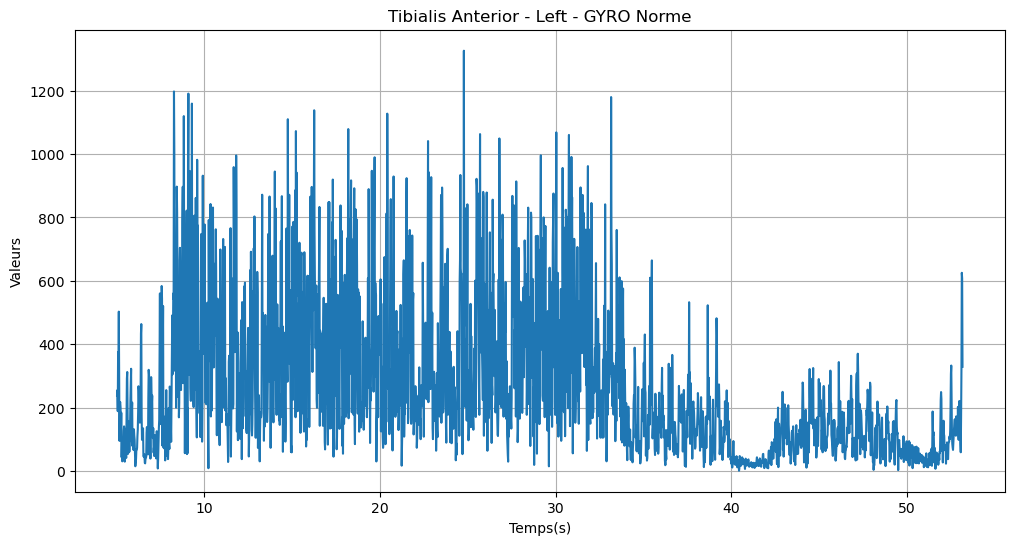

In [6]:
plot_data(data_interval_from_peak, "Tibialis Anterior", "Left","GYRO", "norme", True, data_interval_from_peak["metadata"]["Temps"])


Faut-il redéfinir le temps ? Pour avoir un temps de 0 à ... sachant que dans ces cas là il faudra redéfinir le temps pour chaque évènement

### On applique maintenant la formule de normalisation

In [4]:
def normalize_data(data):
    """
    Normalise les données des capteurs.

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.

    Returns:
    - normalized_data (dict): Un dictionnaire contenant les données normalisées.
    """
    normalized_data = {}
    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            normalized_data[sensor] = {}
            for side, side_data in sensor_data.items():
                normalized_data[sensor][side] = {}
                for measure, measure_data in side_data.items():
                    normalized_data[sensor][side][measure] = {}
                    for axis, axis_data in measure_data.items():
                        # Calculer la moyenne, le maximum et le minimum des données
                        mean = np.mean(axis_data)
                        max_val = np.max(axis_data)
                        min_val = np.min(axis_data)
                        # Appliquer la normalisation sur tous les axes X,Y,Z et la norme
                        normalized_axis_data = (axis_data - mean) / (max_val - min_val)
                        normalized_data[sensor][side][measure][axis] = normalized_axis_data
    
    # Copier les données de "metadata", "Parcours" et "FOG"
    normalized_data["metadata"] = data["metadata"]
    normalized_data["Parcours"] = data["Parcours"]
    normalized_data["FOG"] = data["FOG"]
    
    return normalized_data


normalized_data = normalize_data(data_interval)


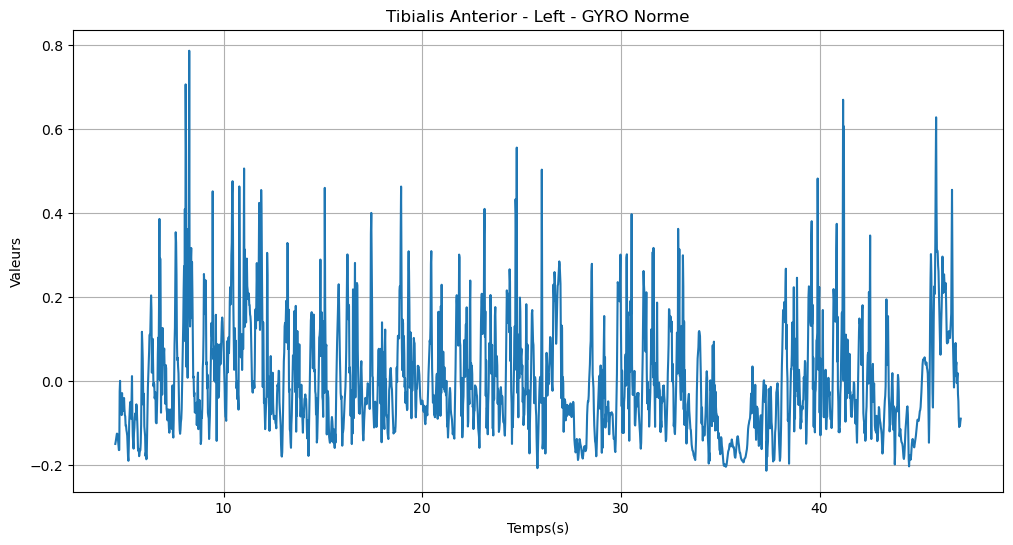

In [14]:
tibia_gyro = donnees_patient_16_update["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
temps = donnees_patient_16_update["metadata"]["Temps"]
plot_data(normalized_data, "Tibialis Anterior", "Left","GYRO", "norme", True, normalized_data["metadata"]["Temps"])


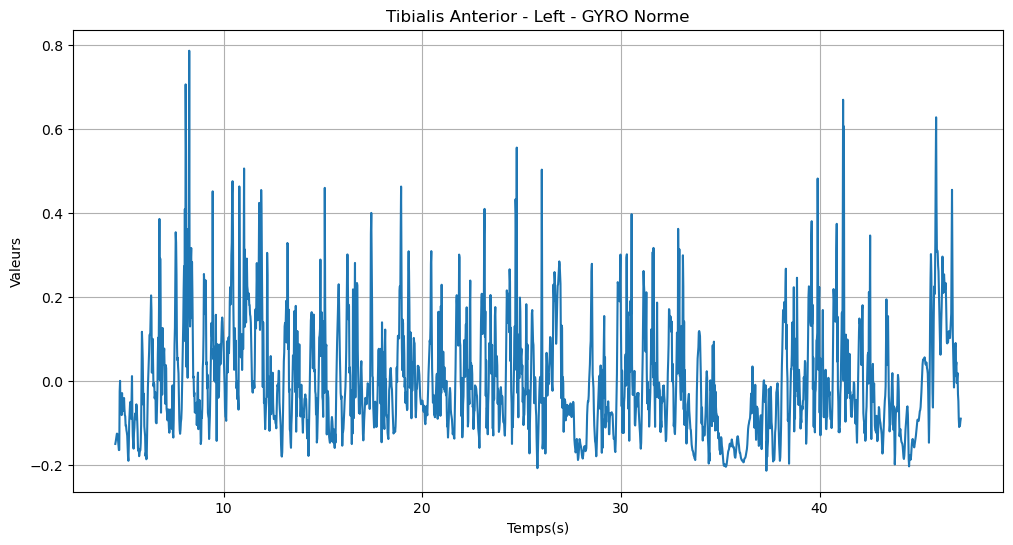

"Le deuxième graph ne fonctionne pas, car j'ai l'impression que le temps à été modifié par la fonction extract_data_interval\nmême si le temps est modifié à l'intérieur de la fonction"

In [26]:
plot_data(normalized_data, "Tibialis Anterior", "Left","GYRO", "norme", True, normalized_data["metadata"]["Temps"])
#plot_data(donnees_patient_16_update, "Tibialis Anterior", "Left","GYRO", "norme", True, donnees_patient_16_update["metadata"]["Temps"])
'''Le deuxième graph ne fonctionne pas, car j'ai l'impression que le temps à été modifié par la fonction extract_data_interval
même si le temps est modifié à l'intérieur de la fonction'''

# Fenêtrage

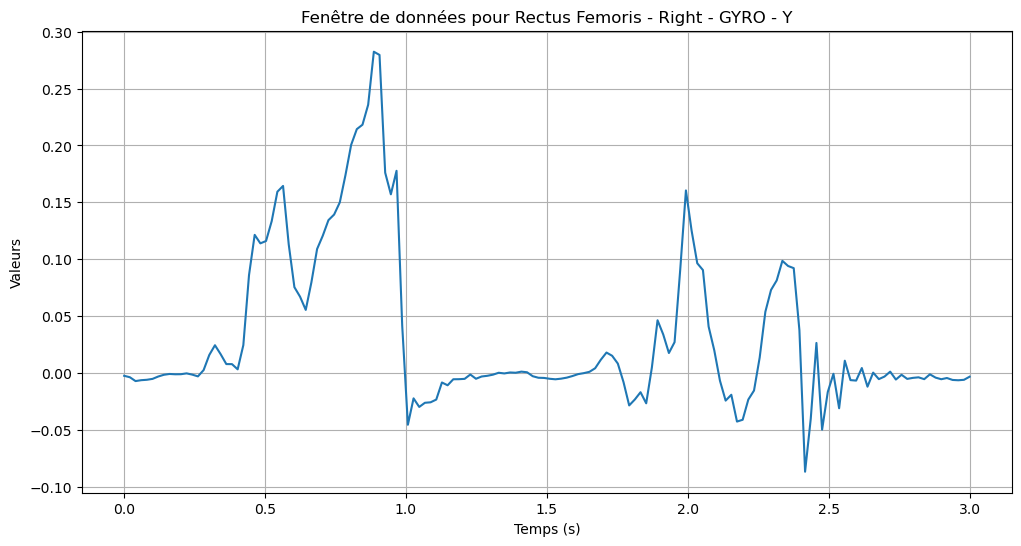

In [23]:
def decoupage_en_fenetres(data, taille_fenetre, decalage,taux_echantillonnage):
    """
    Découpe les données en fenêtres de taille fixe avec un certain décalage.

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.
    - taille_fenetre (float): La taille de la fenêtre en secondes.
    - decalage (float): Le décalage entre les fenêtres en pourcentage de la taille de la fenêtre.
    - taux_echantillonnage (int): Le taux d'échantillonnage des données en Hz.

    Returns:
    - fenetres_data (dict): Un dictionnaire contenant les données découpées en fenêtres.
    - infos_fenetres (dict): Un dictionnaire contenant des informations sur les fenêtres découpées.
    """
    fenetres_data = {}
    infos_fenetres = {}
    
    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            fenetres_data[sensor] = {}
            infos_fenetres[sensor] = {}
            
            for side, side_data in sensor_data.items():
                fenetres_data[sensor][side] = {}
                infos_fenetres[sensor][side] = {}
                
                for measure, measure_data in side_data.items():
                    fenetres_data[sensor][side][measure] = {}
                    infos_fenetres[sensor][side][measure] = {}
                    
                    # Calculer la taille de la fenêtre en nombre d'échantillons
                    for axis, axis_data in measure_data.items():  
                        taille_signal = len(axis_data) # Taille du signal
                        taille_fenetre_echantillons = int(taille_fenetre * taux_echantillonnage) # nb ligne par fenêtre
                        decalage_fenetre = int(decalage * taille_fenetre_echantillons)  # nb de le ligne de décalage

                        fenetres = []
                        debut = 0
                        fin = taille_fenetre_echantillons
                        nb_fenetres = 0
                        
                        # Découper les données en fenêtres
                        while fin <= taille_signal: # Tant que la fin de la fenêtre est inférieure à la taille du signal
                            fenetre = axis_data[debut:fin] # Découper les données en une fenêtre
                            fenetres.append(fenetre)

                            debut = debut + decalage_fenetre # Déplacer le début de la fenêtre
                            fin = fin + decalage_fenetre
                            nb_fenetres += 1
                            
                        # Si la dernière fenêtre ne couvre pas la totalité du signal, ajouter une dernière fenêtre
                        if debut < taille_signal:
                            fenetre = axis_data[debut:]
                            fenetres.append(fenetre)

                        fenetres_data[sensor][side][measure][axis] = fenetres
                        infos_fenetres[sensor][side][measure][axis] = {
                            "nombre_fenetres": nb_fenetres,
                            "taille_fenetre": taille_fenetre_echantillons,
                            "decalage_fenetre": decalage_fenetre
                        }
    
    # Copier les données de "metadata", "Parcours" et "FOG"
    fenetres_data["metadata"] = data["metadata"]
    fenetres_data["Parcours"] = data["Parcours"]
    fenetres_data["FOG"] = data["FOG"]
    
    return fenetres_data, infos_fenetres

fenetres_data, infos_fenetres = decoupage_en_fenetres(normalized_data, taille_fenetre = 3, decalage=0.2, taux_echantillonnage=50)

# Afficher les informations sur les fenêtres
test_info= infos_fenetres["Rectus Femoris"]["Right"]["GYRO"]["Y"]




test= fenetres_data["Rectus Femoris"]["Right"]["GYRO"]["Y"]  
test_gyro = normalized_data["Rectus Femoris"]["Right"]["GYRO"]["Y"] #on regarde la dernière ligne pour vérifier dans test, nous avons bien toutes les données
    
def plot_window(window, sensor, side, measure, axis, sample_rate):  
    # Créer un vecteur de temps pour la fenêtre
    temps_fenetre = np.linspace(0, len(window) / sample_rate, num=len(window))
    
    plt.figure(figsize=(12, 6))
    plt.plot(temps_fenetre, window)
    plt.title(f"Fenêtre de données pour {sensor} - {side} - {measure} - {axis}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Valeurs")
    plt.grid(True)
    plt.show()
    
plot_window(test[10], "Rectus Femoris", "Right", "GYRO", "Y", 50)



# ____________________________________________________________________________________________________________________________________________________________________________________________________

## Conversion C3D en JSON sans rééchantillonnage, ni filtre

In [2]:
def recuperer_evenements(file_path):
    c3d = ezc3d.c3d(file_path)
    events = c3d['parameters']['EVENT']['LABELS']['value']
    frames = c3d['parameters']['EVENT']['TIMES']['value']
    events_dict = {}
    for event, frame in zip(events, frames):
        events_dict[event] = frame
    return events_dict

def associer_labels_et_data(file_path):
    c3d = ezc3d.c3d(file_path)
    labels = c3d['parameters']['ANALOG']['LABELS']['value']
    frequence = c3d['parameters']['ANALOG']['RATE']['value'][0]
    data = c3d['data']['analogs']
    nb_frame = len(data[0][0])
    temps = np.linspace(0., nb_frame / frequence, num=nb_frame)
    fusion_label_data = {}
    for i, label in enumerate(labels):
        fusion_label_data[label] = data[0][i, :]
    return fusion_label_data, temps   # Dictionnaire avec tous les labels associés aux données

def filtrer_labels(fusion_label_data):
    labels_filtre = []
    labels_data_filtre = {}
    for label, valeurs in fusion_label_data.items():
        if 'ACC' in label or 'GYRO' in label:
            labels_filtre.append(label)
            labels_data_filtre[label] = valeurs
    return labels_filtre, labels_data_filtre # Dictionnaire avec les labels filtrés et les données associées

def calcul_norme(labels_data_filtre):
    normes = {}
    traite = set()
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[0]
        side = parts[1]
        measure = parts[2]
        axes = parts[3]
        
        if (sensor, side, measure) not in traite:
            traite.add((sensor, side, measure))
            
            if "ACC" in measure:
                # Obtention des axes X, Y et Z
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
            
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) - 1
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme
                
            else :
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
        
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2)
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme

    return normes

def creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, temps, events_dict, normes):
    json_data = {
        "metadata": {
            "Détails du patient": {
                "Identifiant": patient_id,
                "Date de naissance": date_de_naissance,
                "Medicaments": medicaments
            },
            "Temps": temps.tolist()
        }
    }
    
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]
        
        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        json_data[sensor][side][measure][axis] = value.tolist()
        
    for key in normes:
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]

        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        # Insérer la norme au même niveau d'indentation que l'axe
        json_data[sensor][side][measure][axis] = value.tolist()
        json_data[sensor][side][measure]["norme"] = normes[key].tolist()
    
        # Ajouter les événements FOG
    json_data["FOG"] = {
        "Debut": events_dict["FOG_begin"].tolist(),
        "Fin": events_dict["FOG_end"].tolist()
    }
    
    
    return json_data

    


def creation_json_grace_c3d(file_path, patient_id, date_de_naissance, medicaments, output_path):
    events_dict = recuperer_evenements(file_path) 
    fusion_label_data, temps = associer_labels_et_data(file_path)
    labels_filtre, labels_data_filtre = filtrer_labels(fusion_label_data)
    normes = calcul_norme(labels_data_filtre)
    json_structure = creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, temps, events_dict, normes)
    
    with open(output_path, "w") as fichier_json:
        json.dump(json_structure, fichier_json, indent=4)

# Utilisation de la fonction pour traiter le fichier C3D et générer le fichier JSON
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video_overlay_3.c3d"
patient_id = 1234
date_de_naissance = 45
medicaments = "ON"
chemin_sortie = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/video_overlay_3.json"

creation_json_grace_c3d(fichier_brut, patient_id, date_de_naissance, medicaments, chemin_sortie)


In [3]:
# Charger le fichier JSON
chemin_fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/video_overlay_3.json"
with open(chemin_fichier_json, "r") as fichier_json:
    donnees_patient = json.load(fichier_json)

# Accéder aux données spécifiques
accelerometre_left_Z_rectus_femoris = donnees_patient["Vastus Lateralis"]["Left"]["GYRO"]["norme"]